In [1]:
import numpy as np
import pandas as pd
import invert4geom

import xarray as xr

C:\Users\iii\miniforge3\envs\invert4geom\Lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
#from polartoolkit import fetch, maps, profiles, regions, utils

import polartoolkit as ptk

In [34]:
import os

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

region = ptk.regions.getz_ice_shelf
spacing = 5000

# 1.) Loading Datasets

In [35]:
constraint_points = pd.read_csv('constraint_points.csv')
constraint_points

easting      northing  bed_elevation
0     -1.559078e+06 -1.233548e+06   -3538.024543
1     -1.558187e+06 -1.233347e+06   -3531.229456
2     -1.557547e+06 -1.233500e+06   -3520.570221
3     -1.556466e+06 -1.233429e+06   -3513.796082
4     -1.555333e+06 -1.233868e+06   -3512.433386
...             ...           ...            ...
55221 -1.154000e+06 -6.640000e+05    -957.328003
55222 -1.152750e+06 -6.645000e+05    -961.495514
55223 -1.147000e+06 -6.640000e+05    -362.992767
55224 -1.136500e+06 -6.645000e+05     -96.594223
55225 -1.131000e+06 -6.640000e+05    -701.685425

[55226 rows x 3 columns]

In [36]:
bed_topography = ptk.fetch.bedmap3(layer="bed", region = region, reference="ellipsoid",spacing=spacing)

bed_topography = bed_topography.rename({'x': 'easting', 'y': 'northing'}).to_dataset(name = 'upward')

In [60]:
bed_topography

<xarray.Dataset> Size: 48kB
Dimensions:   (northing: 115, easting: 100)
Coordinates:
  * northing  (northing) float64 920B -1.235e+06 -1.23e+06 ... -6.65e+05
  * easting   (easting) float64 800B -1.625e+06 -1.62e+06 ... -1.13e+06
Data variables:
    upward    (northing, easting) float32 46kB -3.491e+03 -3.476e+03 ... -795.7

In [37]:
gravityanomaly = xr.load_dataset('gravityanomaly.nc')
gravityanomaly

<xarray.Dataset> Size: 3MB
Dimensions:                (northing: 286, easting: 248)
Coordinates:
  * northing               (northing) float64 2kB -1.234e+06 ... -6.64e+05
  * easting                (easting) float64 2kB -1.624e+06 ... -1.13e+06
Data variables:
    gravity_disturbance    (northing, easting) float64 567kB nan nan ... nan nan
    upward                 (northing, easting) float32 284kB 456.5 ... 2.227e+03
    surface_gravity        (northing, easting) float64 567kB -1.271 ... 35.26
    water_surface_gravity  (northing, easting) float64 567kB -0.1568 ... -1.184
    gravity_anomaly        (northing, easting) float64 567kB nan nan ... nan nan

In [39]:
gravityanomaly = xr.load_dataset('gravityanomaly.nc')

resampled_vars = []
for var in gravityanomaly.data_vars:
    resampled_vars.append(
        ptk.resample_grid(gravityanomaly[var], spacing=spacing).rename(var)
    )
gravityanomaly = xr.merge(resampled_vars).rename({'x': 'easting', 'y': 'northing'})
gravityanomaly

<xarray.Dataset> Size: 227kB
Dimensions:                (northing: 114, easting: 99)
Coordinates:
  * northing               (northing) float64 912B -1.23e+06 ... -6.65e+05
  * easting                (easting) float64 792B -1.62e+06 ... -1.13e+06
Data variables:
    gravity_disturbance    (northing, easting) float32 45kB nan nan ... nan nan
    upward                 (northing, easting) float32 45kB 456.4 ... 2.227e+03
    surface_gravity        (northing, easting) float32 45kB -1.588 ... 39.55
    water_surface_gravity  (northing, easting) float32 45kB -0.196 ... -1.383
    gravity_anomaly        (northing, easting) float32 45kB nan nan ... nan nan
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt grdsample @GMTAPI@-S-I-G-M-G-N-000000 -G@GMTAPI@-S-O-G...
    description:   
    actual_range:  [-100.60257721  158.756073  ]
    long_name:     z

# 2.) Creating data instance

In [40]:
gravityanomaly = invert4geom.create_data(gravityanomaly, buffer_width=None, model_type='prisms')
gravityanomaly

<xarray.Dataset> Size: 227kB
Dimensions:                (northing: 114, easting: 99)
Coordinates:
  * northing               (northing) float64 912B -1.23e+06 ... -6.65e+05
  * easting                (easting) float64 792B -1.62e+06 ... -1.13e+06
Data variables:
    gravity_disturbance    (northing, easting) float32 45kB nan nan ... nan nan
    upward                 (northing, easting) float32 45kB 456.4 ... 2.227e+03
    surface_gravity        (northing, easting) float32 45kB -1.588 ... 39.55
    water_surface_gravity  (northing, easting) float32 45kB -0.196 ... -1.383
    gravity_anomaly        (northing, easting) float32 45kB nan nan ... nan nan
Attributes:
    region:        (-1620000.0, -1130000.0, -1230000.0, -665000.0)
    spacing:       5000.0
    buffer_width:  50000.0
    inner_region:  (-1570000.0, -1180000.0, -1180000.0, -715000.0)
    dataset_type:  data
    model_type:    prisms

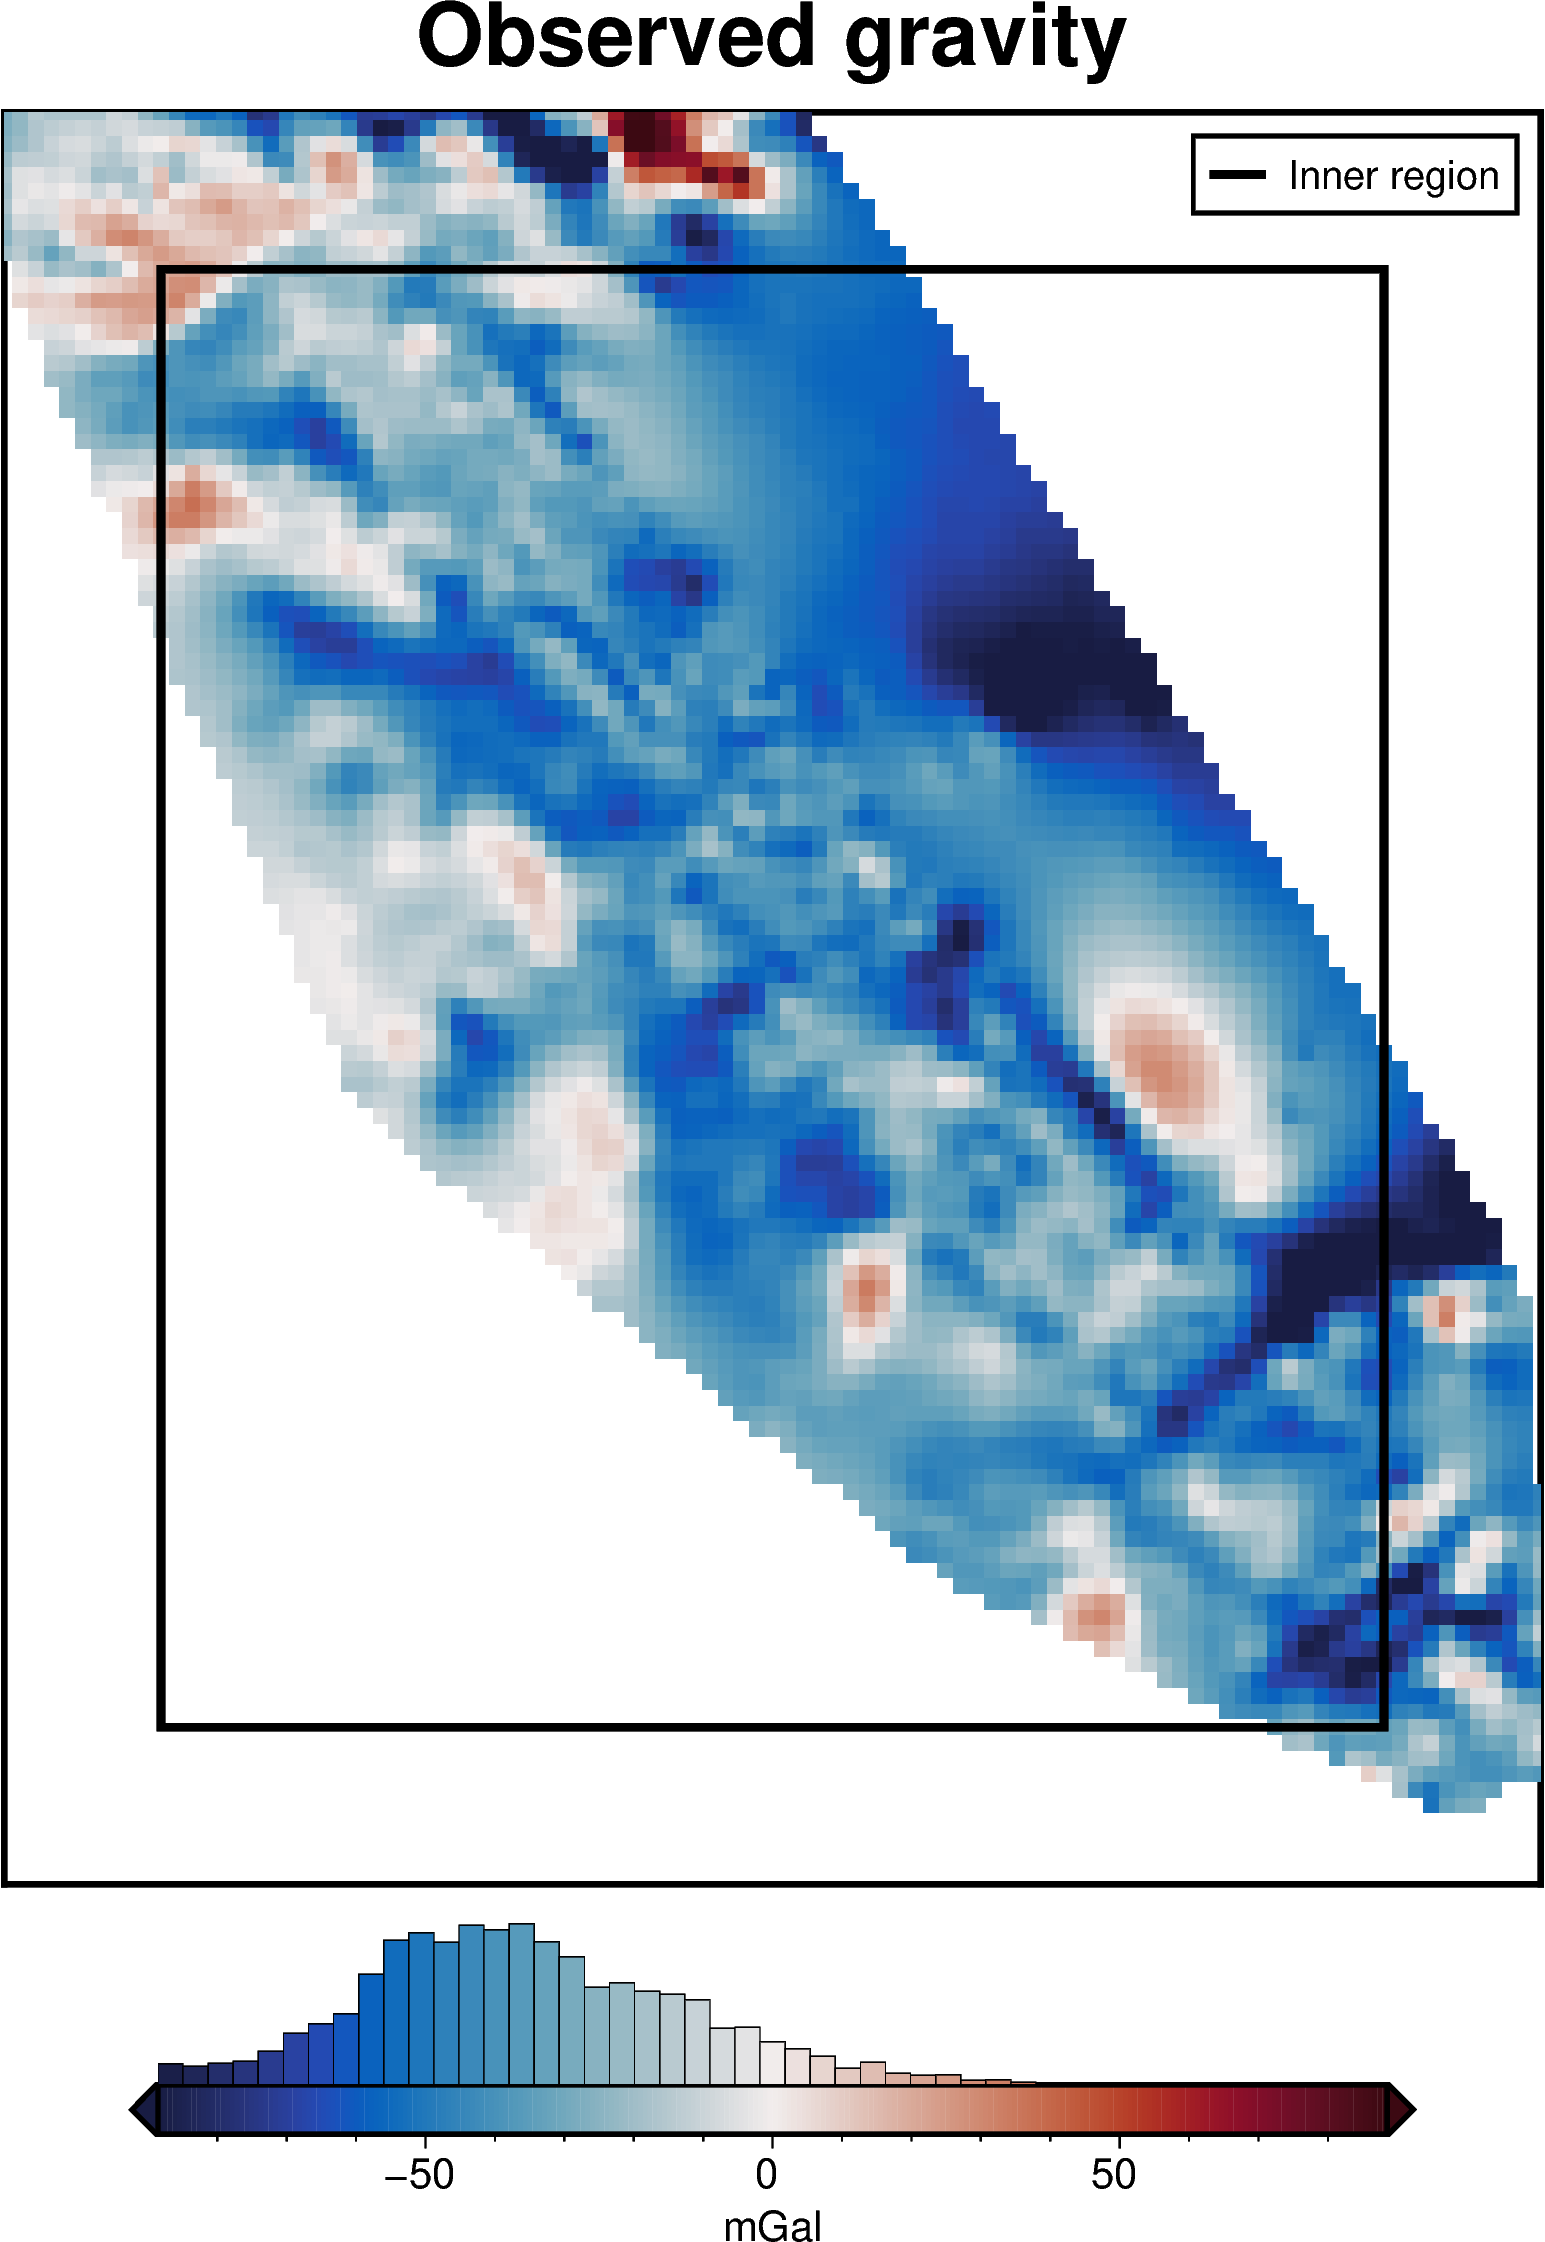

In [41]:
gravityanomaly.inv.plot_observed()

In [42]:
water_surface = ptk.fetch.bedmap3(layer = 'icebase', region = region, reference="ellipsoid",spacing = spacing)
water_surface = water_surface.rename( {'x': 'easting', 'y': 'northing'})


In [43]:
model = invert4geom.create_model(
     zref = 0,
     density_contrast= 2600 - 1030, topography = bed_topography, upper_confining_layer=water_surface

)
model

<xarray.Dataset> Size: 600kB
Dimensions:                (northing: 115, easting: 100)
Coordinates:
  * northing               (northing) float64 920B -1.235e+06 ... -6.65e+05
  * easting                (easting) float64 800B -1.625e+06 ... -1.13e+06
    top                    (northing, easting) float32 46kB 0.0 0.0 ... 0.0 0.0
    bottom                 (northing, easting) float64 92kB -3.491e+03 ... -7...
Data variables:
    density                (northing, easting) int64 92kB -1570 -1570 ... -1570
    thickness              (northing, easting) float64 92kB 3.491e+03 ... 795.7
    starting_topography    (northing, easting) float32 46kB -3.491e+03 ... -7...
    topography             (northing, easting) float32 46kB -3.491e+03 ... -7...
    mask                   (northing, easting) float32 46kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float32 46kB nan nan ... -795.7
    lower_confining_layer  (northing, easting) float64 92kB nan nan ... nan nan
Attributes:
    zref:              0
    density_contrast:  1570
    region:            (-1625000.0, -1130000.0, -1235000.0, -665000.0)
    spacing:           5000.0
    buffer_width:      0
    inner_region:      (-1625000.0, -1130000.0, -1235000.0, -665000.0)
    dataset_type:      model
    model_type:        prisms

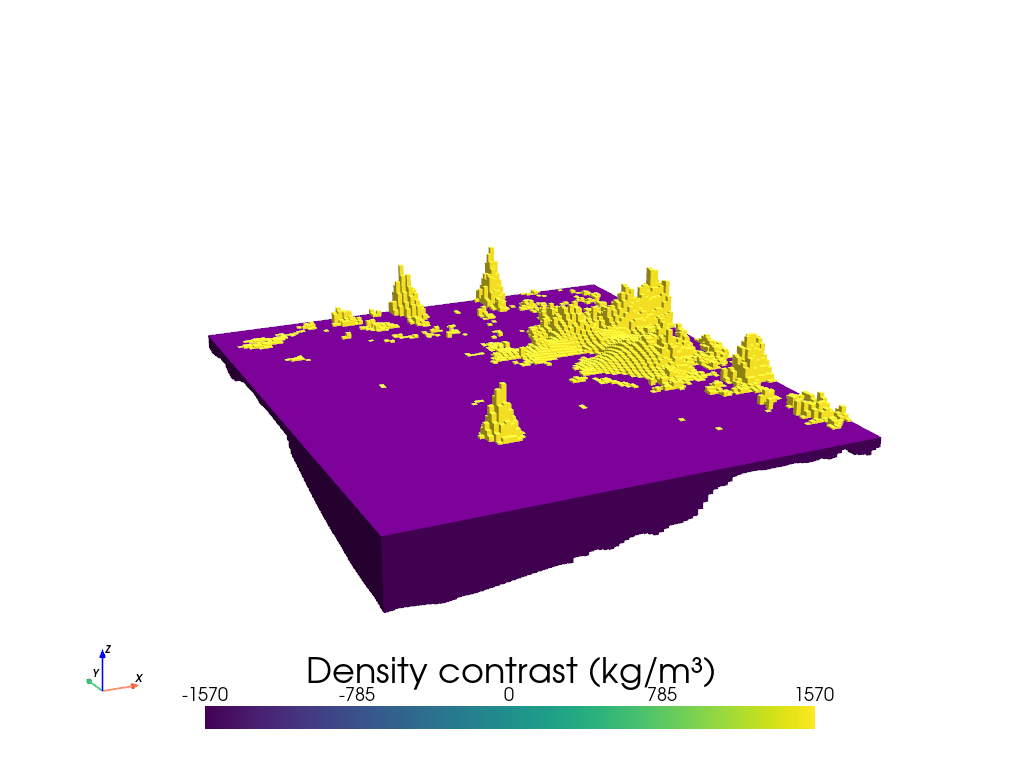

In [44]:
model.inv.plot_model(zscale = 20, color_by = 'density')

# 4.) calculated gravity effect of starting model

In [45]:
gravityanomaly.inv.forward_gravity(model, progressbar=True)
gravityanomaly


  0%|          | 0/5926 [00:00<?, ?it/s]

<xarray.Dataset> Size: 318kB
Dimensions:                (northing: 114, easting: 99)
Coordinates:
  * northing               (northing) float64 912B -1.23e+06 ... -6.65e+05
  * easting                (easting) float64 792B -1.62e+06 ... -1.13e+06
Data variables:
    gravity_disturbance    (northing, easting) float32 45kB nan nan ... nan nan
    upward                 (northing, easting) float32 45kB 456.4 ... 2.227e+03
    surface_gravity        (northing, easting) float32 45kB -1.588 ... 39.55
    water_surface_gravity  (northing, easting) float32 45kB -0.196 ... -1.383
    gravity_anomaly        (northing, easting) float32 45kB nan nan ... nan nan
    forward_gravity        (northing, easting) float64 90kB nan nan ... nan nan
Attributes:
    region:        (-1620000.0, -1130000.0, -1230000.0, -665000.0)
    spacing:       5000.0
    buffer_width:  50000.0
    inner_region:  (-1570000.0, -1180000.0, -1180000.0, -715000.0)
    dataset_type:  data
    model_type:    prisms

# 5.) Gravity misfit

In [46]:
# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
gravityanomaly.inv.regional_separation(
   constraints_df = constraint_points,
    method="constraints",
    tension_factor=0.3,
    grid_method= 'pygmt',
)
gravityanomaly

<xarray.Dataset> Size: 859kB
Dimensions:                   (northing: 114, easting: 99)
Coordinates:
  * northing                  (northing) float64 912B -1.23e+06 ... -6.65e+05
  * easting                   (easting) float64 792B -1.62e+06 ... -1.13e+06
Data variables: (12/13)
    gravity_disturbance       (northing, easting) float32 45kB nan nan ... nan
    upward                    (northing, easting) float32 45kB 456.4 ... 2.22...
    surface_gravity           (northing, easting) float32 45kB -1.588 ... 39.55
    water_surface_gravity     (northing, easting) float32 45kB -0.196 ... -1.383
    gravity_anomaly           (northing, easting) float32 45kB nan nan ... nan
    forward_gravity           (northing, easting) float64 90kB nan nan ... nan
    ...                        ...
    reg                       (northing, easting) float32 45kB 120.2 ... -230.0
    res                       (northing, easting) float64 90kB nan nan ... nan
    starting_forward_gravity  (northing, easting) float64 90kB nan nan ... nan
    starting_misfit           (northing, easting) float64 90kB nan nan ... nan
    starting_reg              (northing, easting) float32 45kB 120.2 ... -230.0
    starting_res              (northing, easting) float64 90kB nan nan ... nan
Attributes:
    region:        (-1620000.0, -1130000.0, -1230000.0, -665000.0)
    spacing:       5000.0
    buffer_width:  50000.0
    inner_region:  (-1570000.0, -1180000.0, -1180000.0, -715000.0)
    dataset_type:  data
    model_type:    prisms

C:\Users\iii\miniforge3\envs\invert4geom\Lib\site-packages\polartoolkit\maps.py:1422: UserWarning:

Since limits were passed to `cpt_lims`, parameter `robust` is unused.

C:\Users\iii\miniforge3\envs\invert4geom\Lib\site-packages\polartoolkit\maps.py:1422: UserWarning:

Since limits were passed to `cpt_lims`, parameter `robust` is unused.



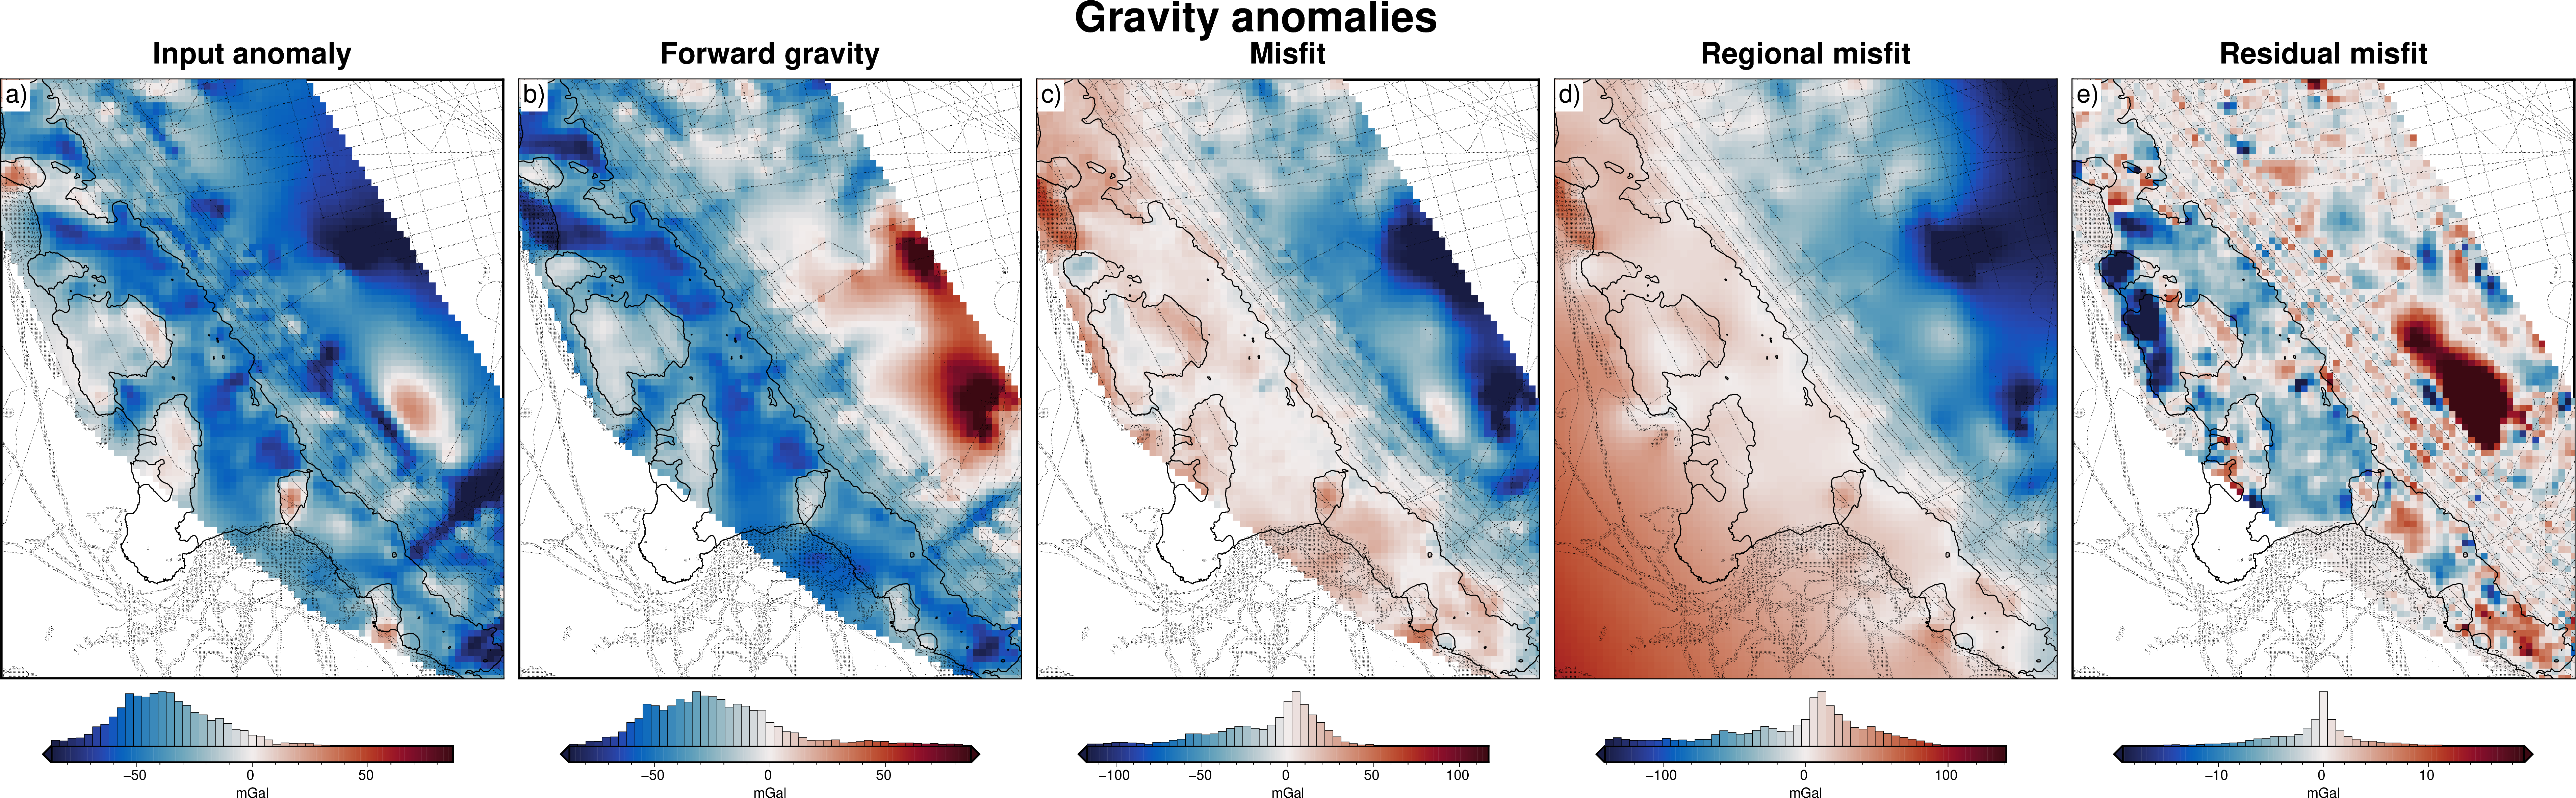

In [47]:
gravityanomaly.inv.plot_anomalies(coast=True, points=constraint_points, points_style='p.2p')

# 7.) Run Inversion

In [48]:
# setup the inversion
invs = invert4geom.Inversion(
    gravityanomaly,
    model,
    solver_damping=0.04,        #normal = 0.05
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=2,  # stop if L2-norm < 2 mGal (RMSE of 4 mGal)
    delta_l2_norm_tolerance=1.01,  # stop if iteration's change in L2-norm < 1%
)
invs.__dict__

{'data': <xarray.Dataset> Size: 859kB
 Dimensions:                   (northing: 114, easting: 99)
 Coordinates:
   * northing                  (northing) float64 912B -1.23e+06 ... -6.65e+05
   * easting                   (easting) float64 792B -1.62e+06 ... -1.13e+06
 Data variables: (12/13)
     gravity_disturbance       (northing, easting) float32 45kB nan nan ... nan
     upward                    (northing, easting) float32 45kB 456.4 ... 2.22...
     surface_gravity           (northing, easting) float32 45kB -1.588 ... 39.55
     water_surface_gravity     (northing, easting) float32 45kB -0.196 ... -1.383
     gravity_anomaly           (northing, easting) float32 45kB nan nan ... nan
     forward_gravity           (northing, easting) float64 90kB nan nan ... nan
     ...                        ...
     reg                       (northing, easting) float32 45kB 120.2 ... -230.0
     res                       (northing, easting) float64 90kB nan nan ... nan
     starting_forward_gr

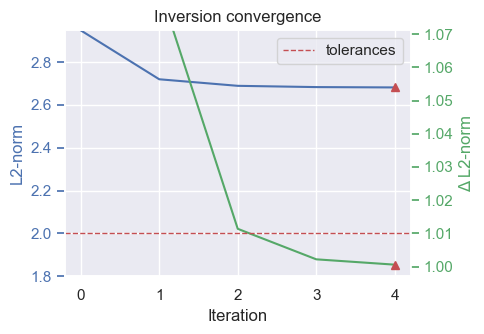

In [49]:
invs.invert(plot_dynamic_convergence=True)


In [50]:
invs.termination_reason

['delta l2-norm tolerance']

In [51]:
invs.stats_df

iteration      rmse   l2_norm  delta_l2_norm  iter_time_sec
0        0.0  8.692178  2.948250            inf            NaN
1        1.0  7.397066  2.719755       1.084013       7.906651
2        2.0  7.231464  2.689138       1.011385       8.713560
3        3.0  7.199729  2.683231       1.002202       6.640684
4        4.0  7.191159  2.681634       1.000596       6.675356

In [52]:
invs.model

<xarray.Dataset> Size: 3MB
Dimensions:                (northing: 115, easting: 100)
Coordinates:
  * northing               (northing) float64 920B -1.235e+06 ... -6.65e+05
  * easting                (easting) float64 800B -1.625e+06 ... -1.13e+06
    top                    (northing, easting) float64 92kB 0.0 0.0 ... 0.0 0.0
    bottom                 (northing, easting) float64 92kB -3.491e+03 ... -7...
Data variables: (12/28)
    density                (northing, easting) int64 92kB -1570 -1570 ... -1570
    thickness              (northing, easting) float64 92kB 3.491e+03 ... 795.7
    starting_topography    (northing, easting) float32 46kB -3.491e+03 ... -7...
    topography             (northing, easting) float64 92kB -3.491e+03 ... -7...
    mask                   (northing, easting) float32 46kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float32 46kB nan nan ... -795.7
    ...                     ...
    topography_correction  (northing, easting) float64 92kB 0.01308 ... 0.0
    iter_4_top             (northing, easting) float64 92kB 0.0 0.0 ... 0.0 0.0
    iter_4_bottom          (northing, easting) float64 92kB -3.491e+03 ... -7...
    iter_4_density         (northing, easting) int64 92kB -1570 -1570 ... -1570
    iter_4_layer           (northing, easting) float64 92kB -3.491e+03 ... -7...
    iter_4_correction      (northing, easting) float64 92kB 0.01308 ... 0.0
Attributes:
    zref:              0
    density_contrast:  1570
    region:            (-1625000.0, -1130000.0, -1235000.0, -665000.0)
    spacing:           5000.0
    buffer_width:      0
    inner_region:      (-1625000.0, -1130000.0, -1235000.0, -665000.0)
    dataset_type:      model
    model_type:        prisms

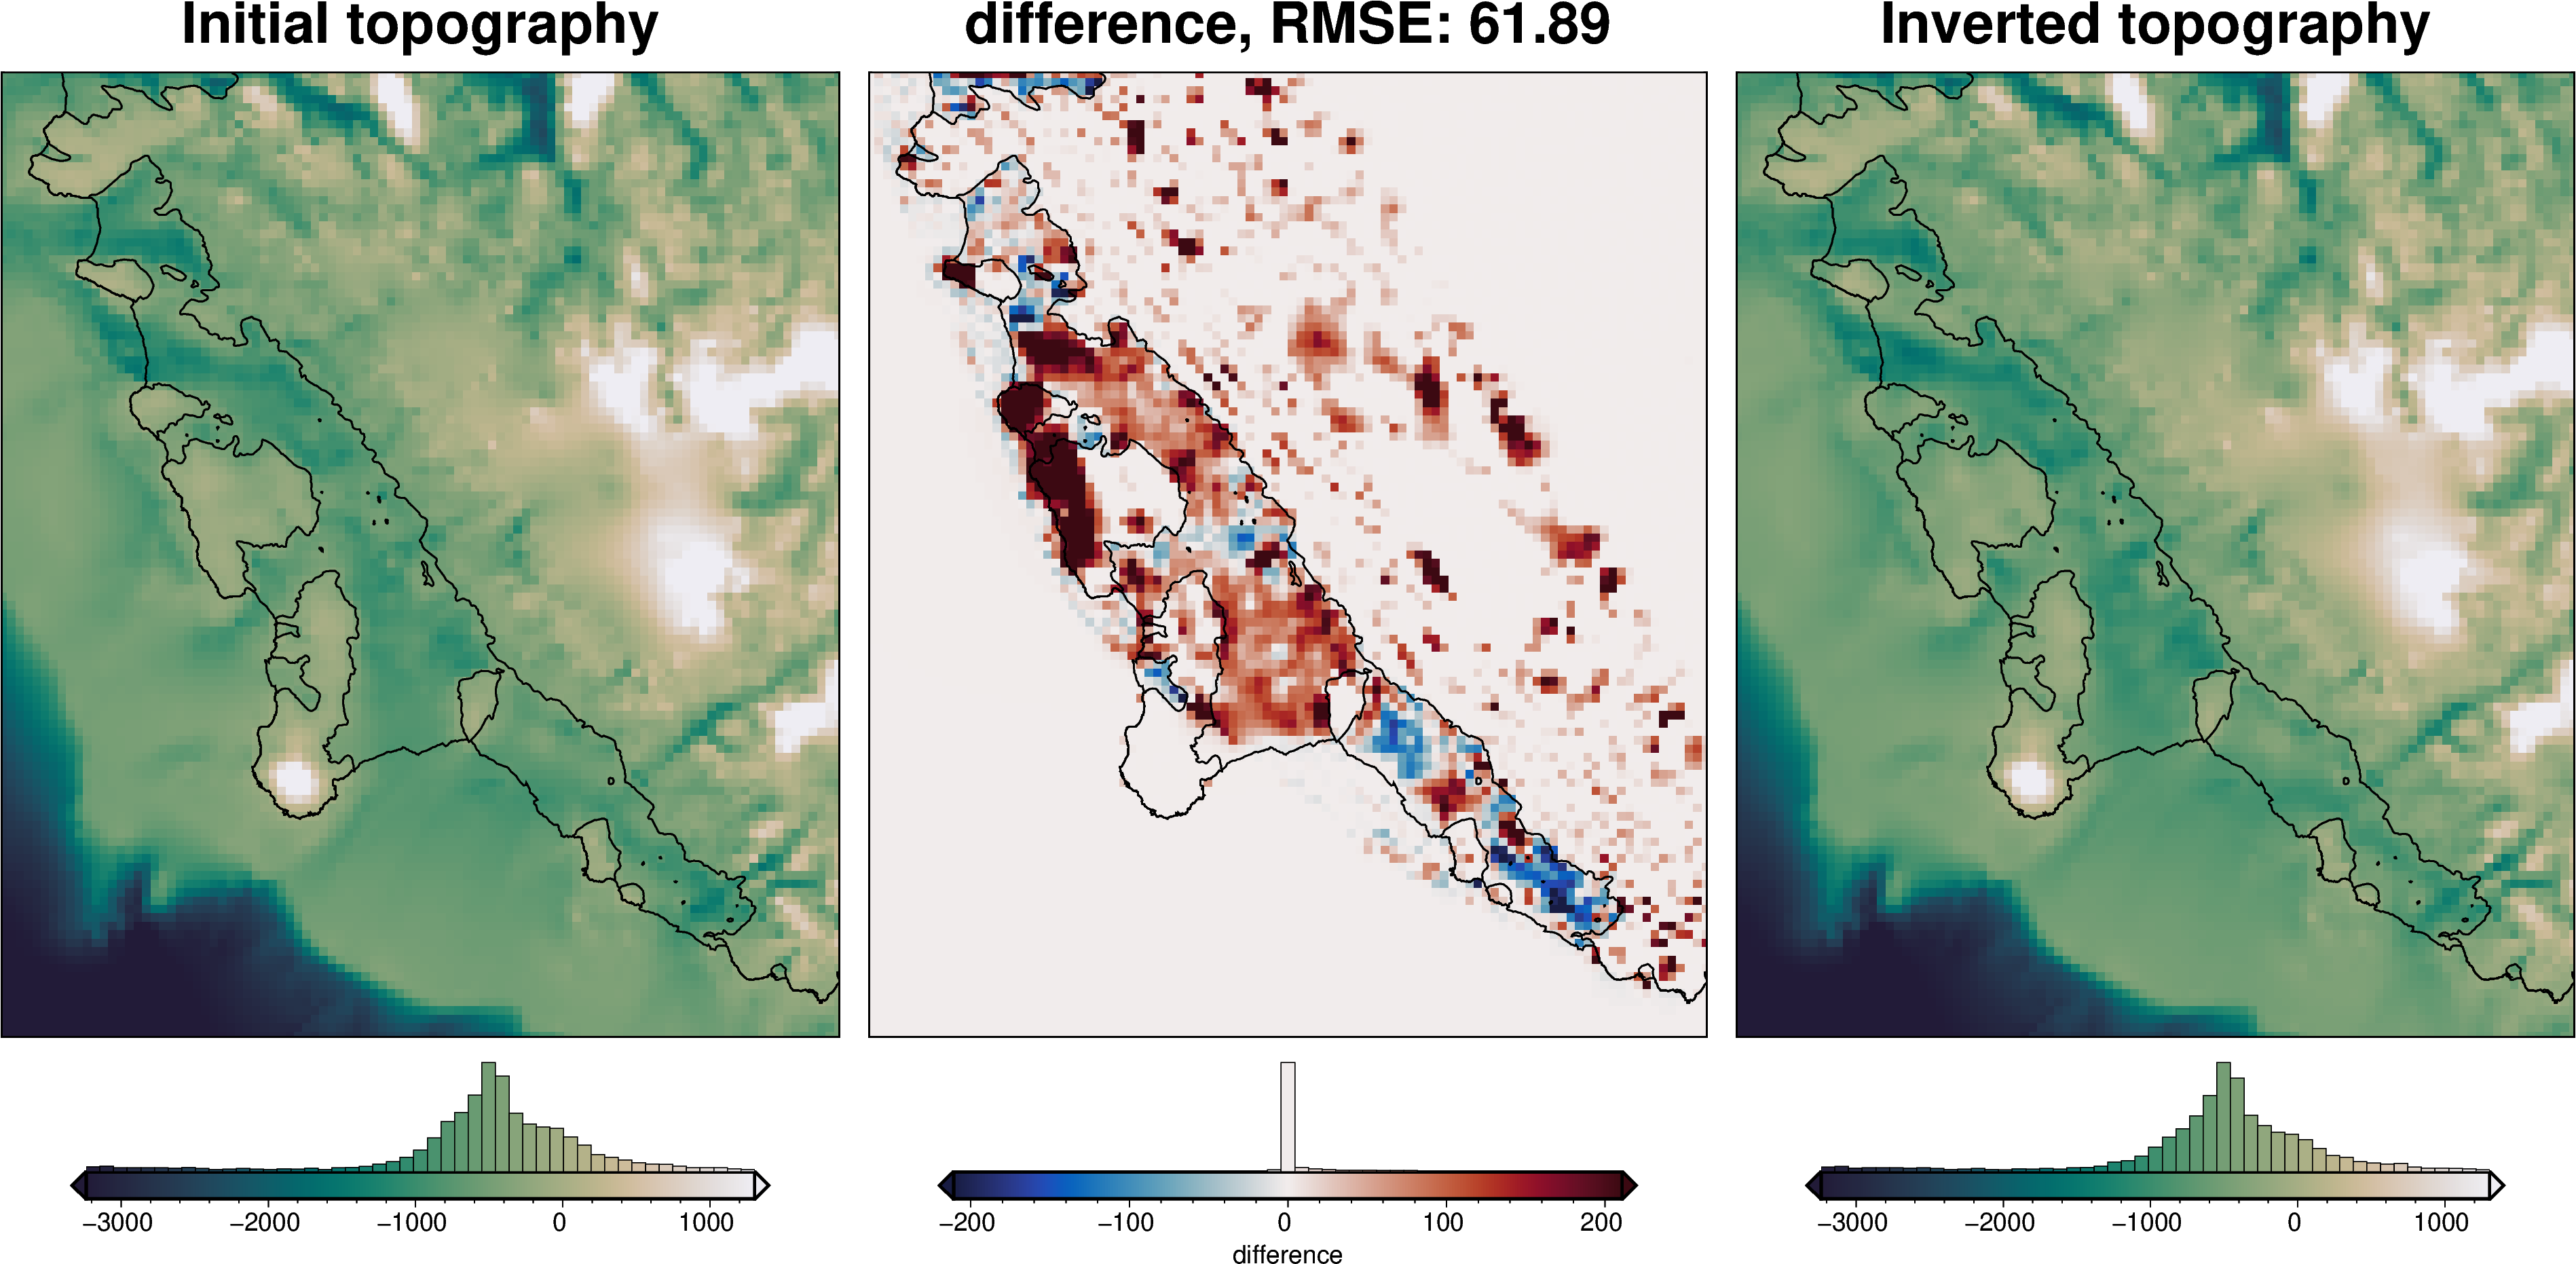

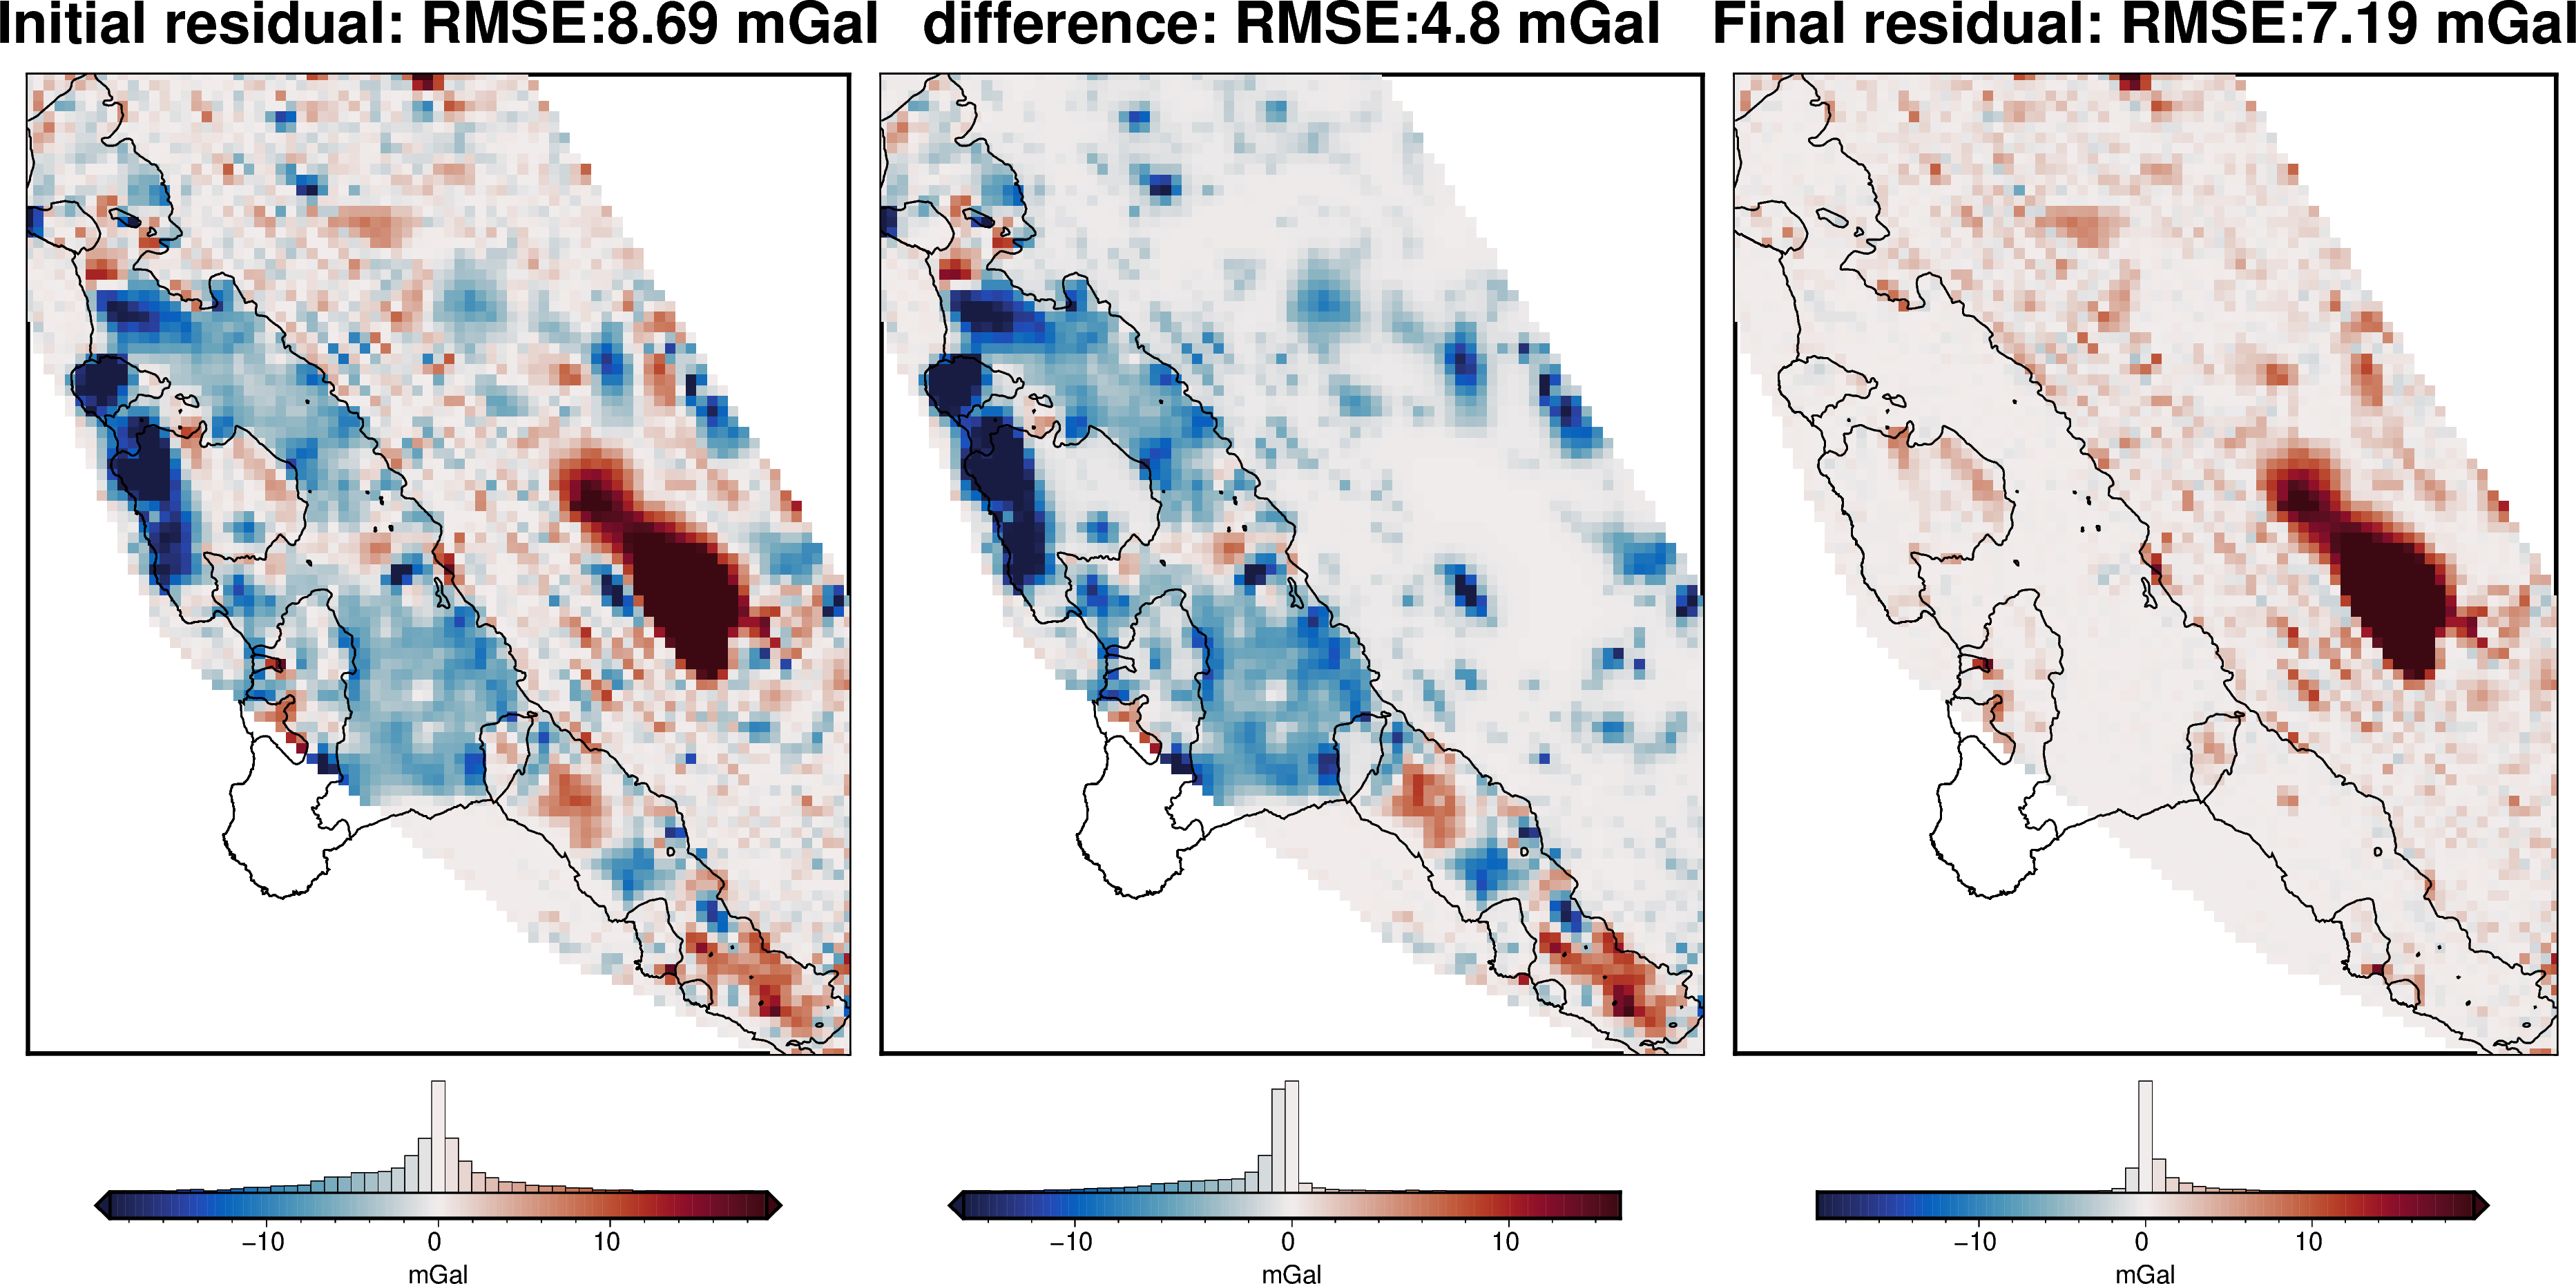

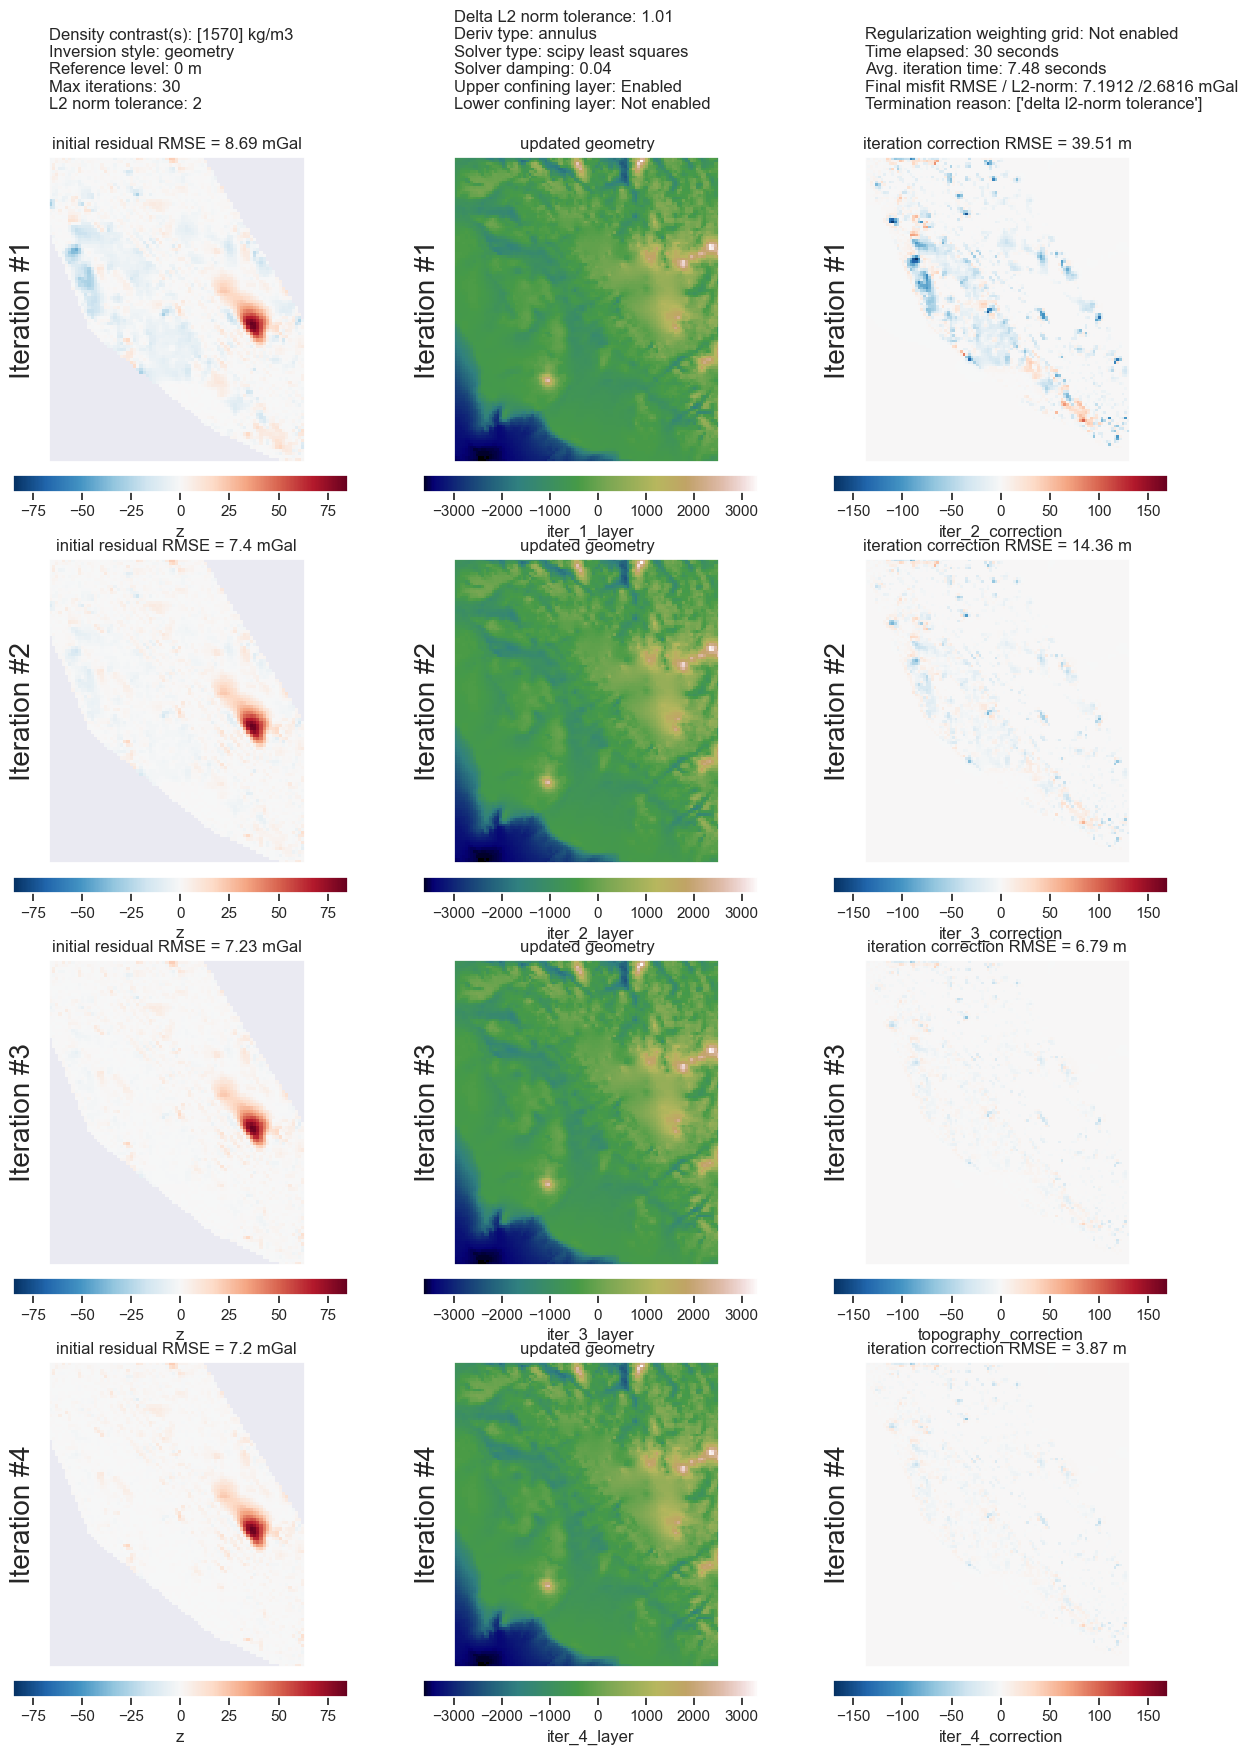

In [53]:
invs.plot_inversion_results(
    coast=True,
)

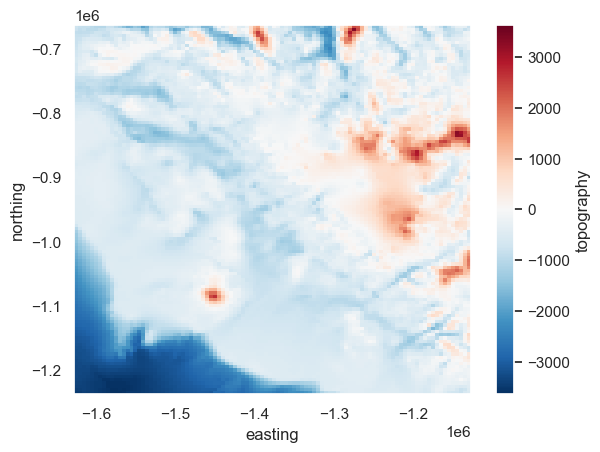

In [54]:
invs.model.topography.plot()

# 8.) Comparision

In [61]:
bed_topography2 = ptk.fetch.bedmap2(layer="bed", region=region, reference="ellipsoid", spacing=spacing)

bed_topography2

bed_topography2 = bed_topography.rename({'easting': 'easting', 'northing': 'northing'}).to_dataset(name='upward')

AttributeError: 'Dataset' object has no attribute 'to_dataset'

In [ ]:
import matplotlib.pyplot as plt

# Assuming your datasets are named ds1 and ds2
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 5))


invs.model.topography.plot(ax = ax1)

bed_topography.upward.plot.pcolormesh(x='easting', y='northing', ax=ax2, robust=True)

